In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


In [2]:
def linear_law(x, a, b):
    return a*x+b

def power_law(x, a, b, c):
    return (x**a)*b + c

def curve_fit_power_law(xdata, ydata, type = "linear"):
    if type == "linear":
        log_xdata = np.log(xdata)
        log_ydata = np.log(ydata)
        popt, pcov = curve_fit(linear_law, log_xdata, log_ydata)
        perr = np.sqrt(np.diag(pcov))
        yfit = np.exp(linear_law(log_xdata, *popt))
        return yfit, popt, perr

    if type == "power":
        popt, pcov = curve_fit(power_law, xdata, ydata)
        perr = np.sqrt(np.diag(pcov))
        return power_law(xdata,*popt), popt, perr
    return ValueError("Shit")

In [3]:
foldername = "/Volumes/SharedDrive/SimResults_Singles/"
df = pd.read_csv(foldername + "sim_9.99900e-01r0_200L_31seed.csv")

In [57]:
name_list = []
r0_list_full = [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95, 0.99,] 
r0_list = r0_list_full
delta_list = [np.abs(np.exp(-r) - np.exp(-1)) for r in r0_list]
dom_list_full = [200, 400, 800]
dom_list = dom_list_full
num_seeds = 32

max_survival_times_dom = []
transverse_length_dom = []
paral_length_dom = []

for dom in dom_list:
    max_survival_times_single_dom = np.zeros((len(r0_list), 2))
    transverse_length_single_dom = np.zeros((len(r0_list), 2))
    parallel_length_single_dom = np.zeros((len(r0_list), 2))

    for r, r_0 in enumerate(r0_list):
        exit_times = np.zeros(32)
        trans_len = np.zeros(32)
        paral_len = np.zeros(32)

        for i, seed in enumerate(range(num_seeds)):
            csv_name = foldername + 'sim_%.5er0_%dL_%dseed.csv'%(r_0, dom, seed)

            try:
                df = pd.read_csv(csv_name)
                exit_times[i] = df["t"].iloc[-1]
                
                len_trans_single = df["trans_len"].iloc[-1]
                trans_len[i] = len_trans_single

                len_paral_single = df["paral_len"].iloc[-1]
                if np.isnan(len_paral_single):
                    len_paral_single = dom-1
                paral_len[i] = len_paral_single

            except FileNotFoundError:
                print("Error File not Found:    ",csv_name)
                exit_times[i] = np.NaN
                paral_len[i]= np.NaN
                trans_len[i]= np.NaN

            except KeyError:
                try:
                    df = pd.read_csv(csv_name)
                    exit_times[i] = df["t"].iloc[-1]
                    trans_len[i] = df["trans_len"].iloc[-1]
                    paral_len[i] = df["paral_len"].iloc[-1]

                    num_survivors = df["num_active_sites"].iloc[-1]
                    if num_survivors > 0:
                        num_survived_per_seed += 1
                except KeyError:
                    print("How did you fuck up this bad?? r0:   ", r_0, "| dom:   ",dom)
                    
        
        max_survival_times_single_dom[r, 0] = np.nanmean(exit_times)
        max_survival_times_single_dom[r, 1] = np.nanstd(exit_times)
        transverse_length_single_dom[r, 0] = np.nanmean(trans_len)
        transverse_length_single_dom[r, 1] = np.nanstd(trans_len)
        parallel_length_single_dom[r, 0] = np.nanmean(paral_len)
        parallel_length_single_dom[r, 1] = np.nanstd(paral_len)
        
    max_survival_times_dom.append(max_survival_times_single_dom)
    transverse_length_dom.append(transverse_length_single_dom)
    paral_length_dom.append(parallel_length_single_dom)

SURVIVAL AT:  0.99 200 1
SURVIVAL AT:  0.99 200 2
SURVIVAL AT:  0.99 200 7
SURVIVAL AT:  0.99 200 11
SURVIVAL AT:  0.99 200 12
SURVIVAL AT:  0.99 200 23
SURVIVAL AT:  0.99 400 1
SURVIVAL AT:  0.99 400 2
SURVIVAL AT:  0.99 400 7
SURVIVAL AT:  0.99 400 11
SURVIVAL AT:  0.99 400 12
SURVIVAL AT:  0.99 400 23
SURVIVAL AT:  0.99 400 25
SURVIVAL AT:  0.99 800 1
SURVIVAL AT:  0.99 800 2
SURVIVAL AT:  0.99 800 7
SURVIVAL AT:  0.99 800 11
SURVIVAL AT:  0.99 800 12
SURVIVAL AT:  0.99 800 23
Error File not Found:     /Volumes/SharedDrive/SimResults_Singles/sim_9.90000e-01r0_800L_24seed.csv
Error File not Found:     /Volumes/SharedDrive/SimResults_Singles/sim_9.90000e-01r0_800L_25seed.csv
Error File not Found:     /Volumes/SharedDrive/SimResults_Singles/sim_9.90000e-01r0_800L_26seed.csv
Error File not Found:     /Volumes/SharedDrive/SimResults_Singles/sim_9.90000e-01r0_800L_27seed.csv
Error File not Found:     /Volumes/SharedDrive/SimResults_Singles/sim_9.90000e-01r0_800L_28seed.csv
Error File not 

In [38]:
max_survival_times = np.array(max_survival_times_dom)
transverse_length = np.array(transverse_length_dom)
parallel_length = np.array(paral_length_dom)

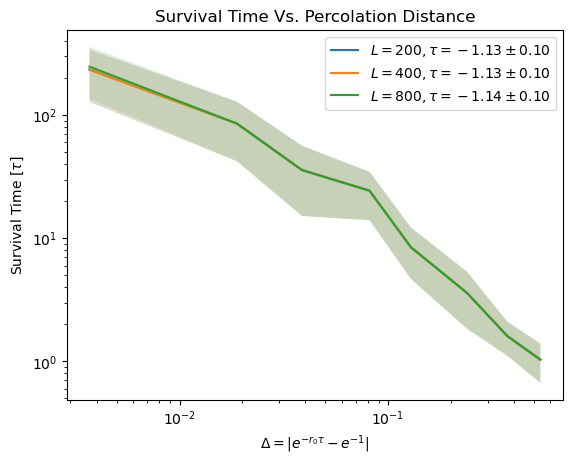

In [47]:
xdata = delta_list
plt.figure()

for i, length in enumerate(dom_list):
    ydata = max_survival_times[i, :, 0]
    ydata_std = max_survival_times[i, :, 1]/np.sqrt(np.size(max_survival_times[i, :, 0]))
    yfit, popt, perr = curve_fit_power_law(xdata, ydata, "linear")
    exp = popt[0]
    exp_err = perr[0]

    # plt.plot(xdata, yfit)
    plt.fill_between(xdata, ydata-ydata_std, ydata+ydata_std, alpha = 0.15)
    plt.plot(xdata, ydata, label = rf"$L = {length}, \tau = {exp:.2f} \pm {exp_err:.2f}$")

plt.title("Survival Time Vs. Percolation Distance")
plt.xlabel(r"$\Delta = |e^{-r_0\tau} - e^{-1}|$")
plt.ylabel(r"Survival Time [$\tau$]")
plt.xscale("log")
plt.yscale("log")
plt.legend()

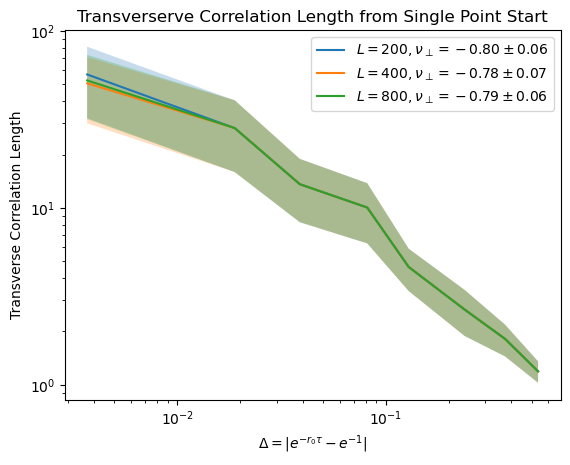

In [39]:
xdata = delta_list
plt.figure()

for i, length in enumerate(dom_list):
    ydata = parallel_length[i, :, 0]
    ydata_std = parallel_length[i, :, 1]/np.sqrt(np.size(parallel_length[i, :, 0]))
    yfit, popt, perr = curve_fit_power_law(xdata, ydata, "linear")
    exp = popt[0]
    exp_err = perr[0]
    
    # plt.plot(xdata, yfit)
    plt.fill_between(xdata, ydata-ydata_std, ydata+ydata_std, alpha = 0.25)
    plt.plot(xdata, ydata, label = rf"$L = {length}, \nu_\bot = {exp:.2f} \pm {exp_err:.2f}$")

plt.title("Transverserve Correlation Length from Single Point Start")
plt.xlabel(r"$\Delta = |e^{-r_0\tau} - e^{-1}|$")
plt.ylabel("Transverse Correlation Length")
plt.xscale("log")
plt.yscale("log")
plt.legend()

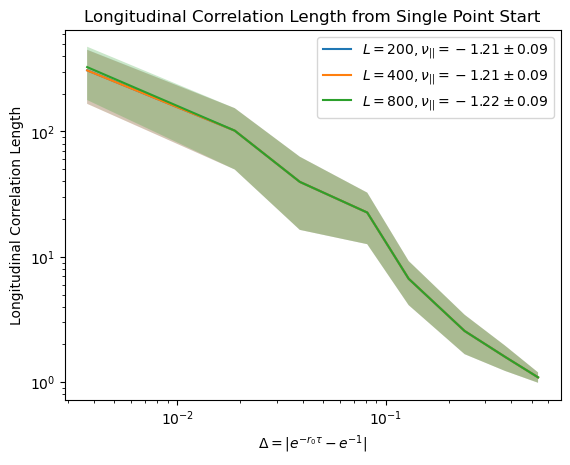

In [40]:
xdata = delta_list

plt.figure()

for i, length in enumerate(dom_list):
    try:
        ydata = transverse_length[i, :, 0]
        ydata_std = transverse_length[i, :, 1]/np.sqrt(np.size(transverse_length[i, :, 0]))
        yfit, popt, perr = curve_fit_power_law(xdata, ydata, "linear")
        exp = popt[0]
        exp_err = perr[0]
        
        # plt.plot(xdata, yfit)
        plt.fill_between(xdata, ydata-ydata_std, ydata+ydata_std, alpha = 0.25)
        plt.plot(xdata, ydata, label = f"$L = {length}," + r"\nu_{||}$" + f"$ = {exp:.2f} \pm {exp_err:.2f}$")
    except ValueError:
        continue

plt.title("Longitudinal Correlation Length from Single Point Start")
plt.xlabel(r"$\Delta = |e^{-r_0\tau} - e^{-1}|$")
plt.ylabel("Longitudinal Correlation Length")
plt.xscale("log")
plt.yscale("log")
plt.legend()

In [ ]:
plt.figure()

for i, length in enumerate(dom_list):
    try:
        ydata = prob_survival[i, :]
        yfit, popt, perr = curve_fit_power_law(xdata, ydata, "power")
        exp = popt[0]
        exp_err = perr[0]
        
        # plt.plot(xdata, yfit)
        plt.plot(xdata, ydata, label = f"$L = {length}," + r"\nu_{||}$" + f"$ = {exp:.2f} \pm {exp_err:.2f}$")
    except ValueError:
        continue

plt.title("Survival Probability from Single Point Start")
plt.xlabel(r"$\Delta = |e^{-r_0\tau} - e^{-1}|$")
plt.ylabel("Probability Simulation Survives")
plt.xscale("log")
# plt.yscale("log")
# plt.legend()

In [ ]:
plt.figure()
plt.plot(xdata, yfit)

In [60]:
df.keys

<bound method NDFrame.keys of           t  num_active_sites  N   h_mean     h_std  trans_len  paral_len  \
0  0.416048                 0  1  0.00125  0.035333          1          1   
1  0.416048                 0  2  0.00250  0.049937          1          1   

    density_last_interval  empty_bond_mass  empty_bond_volume  mean_bond_size  
0                  0.0000                0                  0               0  
1                  0.0005                0                  0               0  >

In [65]:
name_list = []
r0_list = r0_list_full
delta_list = [np.abs(np.exp(-r) - np.exp(-1)) for r in r0_list]
dom_list = [200, 400, 800]

Masses_dom = []
Volumes_dom = []
Sizes_dom = []

for dom in dom_list:
    M_single_dom = np.zeros((len(r0_list), 2))
    V_single_dom = np.zeros((len(r0_list), 2))
    S_single_dom = np.zeros((len(r0_list), 2))

    for r, r_0 in enumerate(r0_list):
        M = np.zeros(32)
        V = np.zeros(32)
        S = np.zeros(32)
        for i, seed in enumerate(range(32)):
            csv_name = foldername + 'sim_%.5er0_%dL_%dseed.csv'%(r_0, dom, seed)
            try:
                df = pd.read_csv(csv_name)
                M[i] = df["empty_bond_mass"].iloc[-1]
                V[i] = df["empty_bond_volume"].iloc[-1]
                S[i] = df["mean_bond_size"].iloc[-1]
            except FileNotFoundError:
                print("FileNotFoundError:   ", csv_name)
                M[i] = np.NaN
                V[i] = np.NaN
                S[i] = np.NaN
            except KeyError:
                try:
                    df = pd.read_csv(csv_name)
                    M[i] = df[" empty_bond_mass"].iloc[-1]
                    V[i] = df[" empty_bond_volume"].iloc[-1]
                    S[i] = df[" empty_bond_size"].iloc[-1]
                except KeyError:
                    M[i] = np.NaN
                    V[i] = np.NaN
                    S[i] = np.NaN
                    print("How did you fuck this up?", f"r0: {r_0}|   seed: {i}")
                    continue
        
        M_single_dom[r, 0] = np.nanmean(M)
        M_single_dom[r, 1] = np.nanstd(M)
        V_single_dom[r, 0] = np.nanmean(V)
        V_single_dom[r, 1] = np.nanstd(V)
        S_single_dom[r, 0] = np.nanmean(S)
        S_single_dom[r, 1] = np.nanstd(S)
        
    Masses_dom.append(M_single_dom)
    Volumes_dom.append(V_single_dom)
    Sizes_dom.append(S_single_dom)

Masses = np.array(Masses_dom).squeeze()
Volumes = np.array(Volumes_dom).squeeze()
Sizes = np.array(Sizes_dom).squeeze()


FileNotFoundError:    /Volumes/SharedDrive/SimResults_Singles/sim_9.90000e-01r0_800L_24seed.csv
FileNotFoundError:    /Volumes/SharedDrive/SimResults_Singles/sim_9.90000e-01r0_800L_25seed.csv
FileNotFoundError:    /Volumes/SharedDrive/SimResults_Singles/sim_9.90000e-01r0_800L_26seed.csv
FileNotFoundError:    /Volumes/SharedDrive/SimResults_Singles/sim_9.90000e-01r0_800L_27seed.csv
FileNotFoundError:    /Volumes/SharedDrive/SimResults_Singles/sim_9.90000e-01r0_800L_28seed.csv
FileNotFoundError:    /Volumes/SharedDrive/SimResults_Singles/sim_9.90000e-01r0_800L_29seed.csv


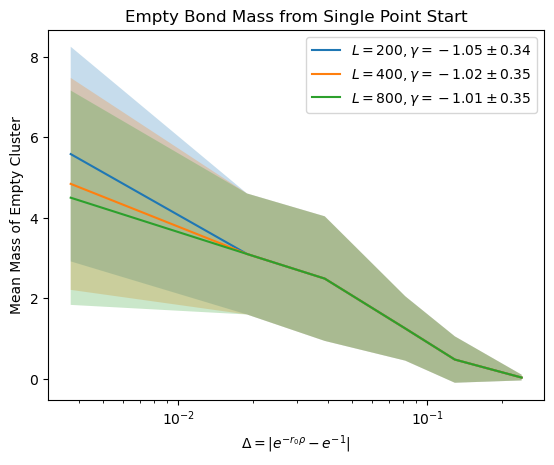

In [81]:
xdata = delta_list
plt.figure()

for i, length in enumerate(dom_list):
    try:
        ydata = Masses[i, :, 0]
        ind_nonzero = np.nonzero(ydata)
        ydata_std = Masses[i, :, 1]/np.sqrt(np.size(Masses[i, :, 0]))
        yfit, popt, perr = curve_fit_power_law(xdata, ydata)
        exp = popt[0]
        exp_err = perr[0]
        
        # plt.plot(xdata, yfit)
        plt.fill_between(xdata, ydata-ydata_std, ydata+ydata_std, alpha = 0.25)
        plt.plot(xdata, ydata, label = rf"$L = {length}, \gamma = {exp:.2f} \pm {exp_err:.2f}$")
    except ValueError:
        continue

plt.title("Empty Bond Mass from Single Point Start")
plt.xlabel(r"$\Delta = |e^{-r_0\tau} - e^{-1}|$")
plt.ylabel("Mean Mass of Empty Cluster")
plt.xscale("log")
plt.legend()

In [ ]:
name_list = []
r0_list_full = [1, ] 
r0_list = r0_list_full
delta_list = [np.abs(np.exp(-r) - np.exp(-1)) for r in r0_list]
dom_list_full = [200, 400, 800]
dom_list = dom_list_full
num_seeds = 32

prob_survival_dom = []

for dom in dom_list:
    prob_survival_single_dom = np.zeros(len(r0_list))

    for r, r_0 in enumerate(r0_list):

        num_active_seeds = 0
        for i, seed in enumerate(range(num_seeds)):
            csv_name = foldername + 'sim_%.5er0_%dL_%dseed.csv'%(r_0, dom, seed)
            num_survived_per_seed = 0

            try:

                num_survivors = df["num_active_sites"].iloc[-1]
                if num_survivors > 0:
                    num_survived_per_seed += 1
                num_active_seeds += 1

            except FileNotFoundError:
                print("Error File not Found:    ",csv_name)

            except KeyError:
                try:

                    num_survivors = df[" num_active_sites"].iloc[-1]
                    if num_survivors > 0:
                        num_survived_per_seed += 1
                except KeyError:
                    print("How did you fuck up this bad?? r0:   ", r_0, "| dom:   ",dom)
                    
        prob_survival_single_dom[r] = num_survived_per_seed/num_active_seeds
    prob_survival_dom.append(prob_survival_single_dom)

In [ ]:
prob_survival = np.array(prob_survival_dom).squeeze()